# Twitter Sentiment Capstone

**Author: Mohamed Emran**

**Date: 6/26/2023**

# Notebook 2 - Advance Modelling

## Table of Contents

1. [Introduction](#Introduction)<br>
2. [Baseline Model](#2.-Baseline-Model)
3. [Advance Modelling](#3.-Advance-Modelling)
4. [Conclusion](#4.-Conclusion)



### 1. Introduction

In the previous notebook, Part 2 Preprocessing we covered Feature Engineering, which involves in Text Vectorizing such as CountVectorizer and TF-IDF Vectorizer, as well we tried out our baseline modelling `Logisitic Regression`.

In this notebook, we will explore supervised machine learning models such as Support Vector Machines (SVM), Random Forest, XGBoost

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Importing library in order to see the progress bar
from tqdm.notebook import tnrange, tqdm_notebook
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import time

# splitting our data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

In [3]:
# Import dataset
X_rem = pd.read_csv('rem_vectorized.csv')
X_test = pd.read_csv('test_vectorized.csv')

y_rem = pd.read_csv('y_rem.csv')
y_test = pd.read_csv('y_test.csv')

In [4]:
X_rem.shape

(63249, 2000)

In [5]:
X_test.shape

(15813, 2000)

In [6]:
y_rem.shape

(63249, 1)

In [7]:
y_test.shape

(15813, 1)

### Split train/test

In [8]:
# Splitting the remainder in two chunks
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.3, stratify=y_rem, random_state=1)

In [9]:
print(f'Shape of X remainder set: {X_rem.shape}')

print(f'Shape of train set: {X_train.shape}')

print(f'Shape of validation set: {X_val.shape}')

print(f'Shape of X-test set: {X_test.shape}')

Shape of X remainder set: (63249, 2000)
Shape of train set: (44274, 2000)
Shape of validation set: (18975, 2000)
Shape of X-test set: (15813, 2000)


### 2. Baseline Model

#### Logistic Regression

In [122]:
# import library
from sklearn.linear_model import LogisticRegression

In [134]:
### Logistic Regression TF-IDF vectorizer

# Initializing Scale
scaler_tfidf = RobustScaler()

# Fitting scale
scaler_tfidf.fit(X_train)

# Transform scale
X_train_scaled = scaler_tfidf.transform(X_train)
X_val_scaled = scaler_tfidf.transform(X_val)
X_test_scaled = scaler_tfidf.transform(X_test)

In [135]:
# instantiate model
logreg_model = LogisticRegression(max_iter=10000, random_state=1)

# fit the model
logreg_model.fit(X_train_scaled, y_train)

# Training and test score
print(f"Train score: {logreg_model.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg_model.score(X_val_scaled, y_val)}")
print(f"Test score: {logreg_model.score(X_test_scaled, y_test)}")

Train score: 0.7714459953923296
Validation score: 0.7432411067193676
Test score: 0.7407829001454499


We ran the base logistic model and we have to keep in mind once we further exlpore other models.

### Model Evaluation

In [125]:
#Import the confusion matrix libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Importing the classification report library
from sklearn.metrics import classification_report

# Importing precision, recall, F1 score libraries
from sklearn.metrics import precision_score, recall_score, f1_score

In [126]:
# Get class predictions
y_pred = logreg_model.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5705,2211
True Positive,1888,6009


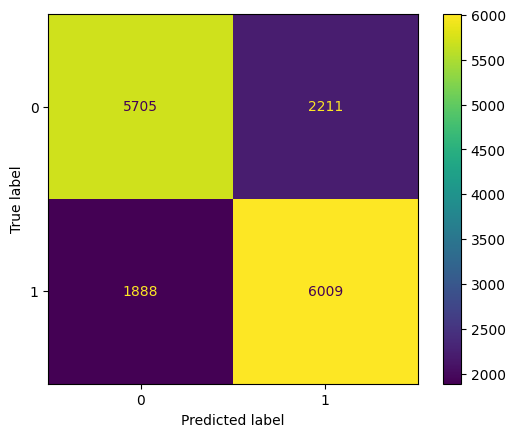

In [127]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model, X_test_scaled, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `5722` are correctly predicted as negative Tweet
* **False Positive**: `2217` that where incorrectly classified as positive Tweet

* **False Negative**: `1866` incorrectly predicted as a negative Tweet 
* **True Positive**: `6008` correctly predicted as postive Tweet

The total of True values (TP + TN) are much higher than the total of False values (FP + FN) indicating a higher accuracy

But with regards to sentiment analysis we want a higher recall rate (how well the model identifies the positive or negative Tweet correctly vs the total positive or negative in the dataset)

In [128]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      7916
           1       0.73      0.76      0.75      7897

    accuracy                           0.74     15813
   macro avg       0.74      0.74      0.74     15813
weighted avg       0.74      0.74      0.74     15813



**Observations:**

* As our base model we have a good accuracy score with `74%`.
    
* Precision shows that 73% of samples predicted class 1 and 75% predicted samples as class 0.
    
* Recall: 76% were predicted right out of all true class instances of class 1 and 72% predicted class 0

In [21]:
# Saving the baseline model - baseline logistic regression
joblib.dump(logreg_model, 'baseline_logreg.pkl')

['baseline_logreg.pkl']

### 3. Advance Modelling

#### ML Pipeline and GridSearch

    1- LogisticRegression
    2- SVM (Support Vector Machines)
    3- Random Forrest (Decision Trees)
    4- XGBoost

In [27]:
# Setting up the estimators and pipeline
estimators = [
    ('scaler', RobustScaler()),
    ('model', LogisticRegression())
]

# Set up a directory to cache the pipeline results
from tempfile import mkdtemp
cachedir = mkdtemp()

# Instantiate the pipeline
my_pipe = Pipeline(estimators, memory=cachedir)

#### Logistic Regression

Our hyperparameter will include

* C_values = [0.001, 0.01, 0.1, 1, 10, 100]
* Penalty = l1, l2
* Solver = liblinear, lbfgs
* Random State = 1
* max_iter = 1000

In [62]:
# logistic Regression
logreg_param_grid = {
    'scaler': [RobustScaler()],
    'model': [LogisticRegression(random_state = 1)],
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__max_iter': [10000]
}

In [63]:
# Instantiate the grid search for each model
logreg_grid = RandomizedSearchCV(my_pipe, param_distributions=logreg_param_grid, cv = 5, verbose = 2)

In [64]:
# Fit the grid search for all models
logreg_fitted_grid = logreg_grid.fit(X_rem, y_rem.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__max_iter=10000, model__penalty=l2, model__solver=liblinear, scaler=RobustScaler(); total time=   5.9s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__max_iter=10000, model__penalty=l2, model__solver=liblinear, scaler=RobustScaler(); total time=   4.6s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__max_iter=10000, model__penalty=l2, model__solver=liblinear, scaler=RobustScaler(); total time=   4.6s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__max_iter=10000, model__penalty=l2, model__solver=liblinear, scaler=RobustScaler(); total time=   4.6s
[CV] END model=LogisticRegression(random_state=1), model__C=0.001, model__max_iter=10000, model__penalty=l2, model__solver=liblinear, scaler=RobustScaler(); total time=   4.7s
[CV] END model=LogisticRegression(random_state=1), model__C

In [65]:
# best score
print(f"best score: {logreg_fitted_grid.best_score_}")

# best parameters
print(f"best parameters: {logreg_fitted_grid.best_params_}")

best score: 0.7471422290565237
best parameters: {'scaler': RobustScaler(), 'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__max_iter': 10000, 'model__C': 1, 'model': LogisticRegression(C=1, max_iter=10000, penalty='l1', random_state=1,
                   solver='liblinear')}


In [66]:
# Saving the model
joblib.dump(logreg_fitted_grid, 'logreg_grid_search.pkl')

['logreg_grid_search.pkl']

In [100]:
print(f"Train Score:\
{logreg_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_train), y_train)}")
print(f"Validation score:\
{logreg_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_val), y_val)}")
print(f"Test Score:\
{logreg_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_test), y_test)}\n")


Train Score:0.7656864073722727
Validation score:0.7635836627140975
Test Score:0.7494466578131916



In [73]:
# Get class predictions
y_pred = logreg_fitted_grid.best_estimator_.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5701,2215
True Positive,1747,6150


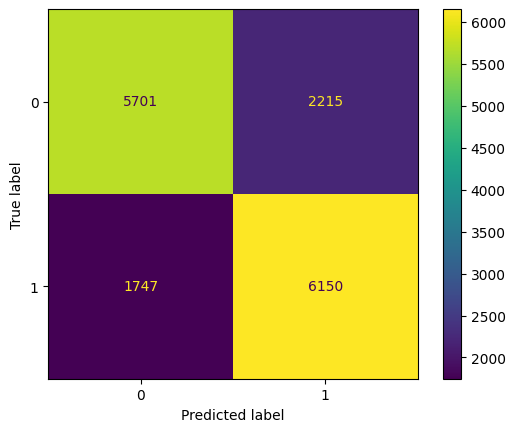

In [74]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_fitted_grid.best_estimator_, X_test_scaled, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `5701` are correctly predicted as negative Tweet
* **False Positive**: `2215` that where incorrectly classified as positive Tweet

* **False Negative**: `1747` incorrectly predicted as a negative Tweet 
* **True Positive**: `6150` correctly predicted as postive Tweet increased after using a hyperparameter


In [87]:
# Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      7916
           1       0.73      0.77      0.75      7897

    accuracy                           0.75     15813
   macro avg       0.75      0.75      0.75     15813
weighted avg       0.75      0.75      0.75     15813



**Observations:**

* Logistic Regression hyperparameter got increase by 1% accuracy score with `75%`.
    
* Precision shows that 74% of samples predicted class 1, which got increased by 1%, and 77% predicted samples as class 0 that got increase by 2%.
    
* Recall: 78% (2% increase) were predicted right out of all true class instances of class 1 and 72% predicted class 0

| GridSearch Best Model | Train Score                                                           | Train Score | Validation score | Test score |
|:---------------------:|-----------------------------------------------------------------------|-------------|:----------------:|:----------:|
|  Logistic Regression  | C=1, max_iter=10000, penalty='l1', random_state=1,,solver='liblinear' | 76.5%       |        76%       |    74.9%   |


|    Baseline Model   |         Default Model Parameters        | Train Score | Validation score | Test score |
|:-------------------:|:---------------------------------------:|:-----------:|:----------------:|:----------:|
| Logistic Regression | C = 1, penalty = 'l2', solver = 'lbfgs' |     77%     |       74.3%      |    74.1%   |

After running our first grid search we are able to identify the best parameter in `Logistic Regression`. We observe that validation score got higher than the `Baseline Model` with 76% a 2%  increase.

Let's move on to the next model using SVM

#### SVM (Support Vector Machines)

Our hyperparameter will include

* C_values = [0.01, 0.1, 1]
* Penalty = l1, l2
* max_iter = 1000
* random_state = 1

In [54]:
# SVM
svm_param_grid = {
    'scaler': [RobustScaler()],
    'model': [LinearSVC(random_state = 1)],
    'model__C': [0.01, 0.1, 1],
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [10000]
}

In [55]:
# Instantiate the grid search
svm_grid = GridSearchCV(my_pipe, param_grid=svm_param_grid, cv = 5, verbose = 2)

In [56]:
# Fit the grid search
svm_fitted_grid = svm_grid.fit(X_rem, y_rem.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END model=LinearSVC(random_state=1), model__C=0.01, model__max_iter=10000, model__penalty=l1, scaler=RobustScaler(); total time=  12.7s
[CV] END model=LinearSVC(random_state=1), model__C=0.01, model__max_iter=10000, model__penalty=l1, scaler=RobustScaler(); total time=   9.9s
[CV] END model=LinearSVC(random_state=1), model__C=0.01, model__max_iter=10000, model__penalty=l1, scaler=RobustScaler(); total time=  11.1s
[CV] END model=LinearSVC(random_state=1), model__C=0.01, model__max_iter=10000, model__penalty=l1, scaler=RobustScaler(); total time=  11.0s
[CV] END model=LinearSVC(random_state=1), model__C=0.01, model__max_iter=10000, model__penalty=l1, scaler=RobustScaler(); total time=  11.1s
[CV] END model=LinearSVC(random_state=1), model__C=0.01, model__max_iter=10000, model__penalty=l2, scaler=RobustScaler(); total time=   4.6s
[CV] END model=LinearSVC(random_state=1), model__C=0.01, model__max_iter=10000, model__penalty

In [76]:
# best score
print(f"best score: {svm_fitted_grid.best_score_}")

# best parameters
print(f"best parameters: {svm_fitted_grid.best_params_}")

best score: 0.7464149638287892
best parameters: {'model': LinearSVC(C=0.1, max_iter=10000, random_state=1), 'model__C': 0.1, 'model__max_iter': 10000, 'model__penalty': 'l2', 'scaler': RobustScaler()}


In [99]:
print(f"Train Score:\
{svm_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_train), y_train)}")
print(f"Validation score:\
{svm_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_val), y_val)}")
print(f"Test Score:\
{svm_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_test), y_test)}\n")

Train Score:0.7660477932872566
Validation score:0.7640579710144928
Test Score:0.745715550496427



In [78]:
# Get class predictions
y_pred = svm_fitted_grid.best_estimator_.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5708,2208
True Positive,1813,6084


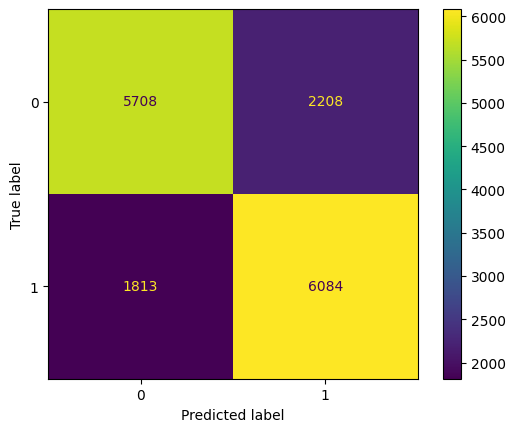

In [79]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(svm_fitted_grid.best_estimator_, X_test_scaled, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `5708` are correctly predicted as negative Tweet
* **False Positive**: `2208` that where incorrectly classified as positive Tweet

* **False Negative**: `1813` incorrectly predicted as a negative Tweet 
* **True Positive**: `6084` correctly predicted as postive Tweet


In [80]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      7916
           1       0.73      0.77      0.75      7897

    accuracy                           0.75     15813
   macro avg       0.75      0.75      0.75     15813
weighted avg       0.75      0.75      0.75     15813



**Observations:**

* SVM has the same accuracy score of 75% 
    
* Precision shows that 73% of samples predicted class 1, and 76% predicted samples as class 0.
    
* Recall: 77% were predicted right out of all true class instances of class 1 and 72% predicted class 0

| GridSearch Best Model |                              Train Score                              | Train Score | Validation score | Test score |
|:---------------------:|:---------------------------------------------------------------------:|:-----------:|:----------------:|:----------:|
|  Logistic Regression  | C=1, max_iter=10000, penalty='l1', random_state=1,,solver='liblinear' |    76.5%    |        76%       |    74.9%   |
|       LinearSVC       |          C=0.1, max_iter=10000, random_state=1, penalty='l2'          |    76.6%    |       76.4%      |    74.5%   |


|    Baseline Model   |         Default Model Parameters        | Train Score | Validation score | Test score |
|:-------------------:|:---------------------------------------:|:-----------:|:----------------:|:----------:|
| Logistic Regression | C = 1, penalty = 'l2', solver = 'lbfgs' |     77%     |       74.3%      |    74.1%   |

Running our second model is a bit better compare to Logistic regression hyperparamter. We can see that the `Validation` score is a bit higher with 76.4%

In [81]:
# Saving our SVM model to a pickle file
joblib.dump(svm_fitted_grid, 'svm_model.pkl')

['svm_model.pkl']

In [82]:
# sanity check - if loads
svm_fitted_grid = joblib.load('svm_model.pkl')

In [86]:
# sanity check to make sure the models are loaded correctly
svm_fitted_grid.best_params_

{'model': LinearSVC(C=0.1, max_iter=10000, random_state=1),
 'model__C': 0.1,
 'model__max_iter': 10000,
 'model__penalty': 'l2',
 'scaler': RobustScaler()}

Let's move on to the next model using Random Forest model after we looked at Logistic and SVM

#### Random Forest

Our hyperparameter will include

* n_estimators = range(50, 201, 50)
* max_depth = range(3, 12, 2)
* random_state = 1

In [89]:
# Random Forest
rf_param_grid = {
    'scaler': [RobustScaler()],
    'model': [RandomForestClassifier(random_state = 1)],
    'model__n_estimators': range(50, 201, 50),
    'model__max_depth': range(3, 12, 2)
}

In [90]:
# Instantiate the grid search
rf_grid = GridSearchCV(my_pipe, param_grid=rf_param_grid, cv = 5, verbose = 2)

In [91]:
# Fit the grid search
rf_fitted_grid = rf_grid.fit(X_rem, y_rem.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model=RandomForestClassifier(random_state=1), model__max_depth=3, model__n_estimators=50, scaler=RobustScaler(); total time=   4.4s
[CV] END model=RandomForestClassifier(random_state=1), model__max_depth=3, model__n_estimators=50, scaler=RobustScaler(); total time=   4.2s
[CV] END model=RandomForestClassifier(random_state=1), model__max_depth=3, model__n_estimators=50, scaler=RobustScaler(); total time=   4.2s
[CV] END model=RandomForestClassifier(random_state=1), model__max_depth=3, model__n_estimators=50, scaler=RobustScaler(); total time=   4.2s
[CV] END model=RandomForestClassifier(random_state=1), model__max_depth=3, model__n_estimators=50, scaler=RobustScaler(); total time=   4.2s
[CV] END model=RandomForestClassifier(random_state=1), model__max_depth=3, model__n_estimators=100, scaler=RobustScaler(); total time=   5.6s
[CV] END model=RandomForestClassifier(random_state=1), model__max_depth=3, model__n_estimat

In [92]:
# best score
print(f"best score: {rf_fitted_grid.best_score_}")

# best parameters
print(f"best parameters: {rf_fitted_grid.best_params_}")

best score: 0.6926592031678049
best parameters: {'model': RandomForestClassifier(max_depth=11, n_estimators=200, random_state=1), 'model__max_depth': 11, 'model__n_estimators': 200, 'scaler': RobustScaler()}


In [93]:
# Saving the best final model - baseline logistic regression
joblib.dump(rf_fitted_grid, 'rf_model.pkl')

['rf_model.pkl']

In [97]:
print(f"Train Score:\
{rf_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_train), y_train)}")
print(f"Validation score:\
{rf_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_val), y_val)}")
print(f"Test Score:\
{rf_fitted_grid.best_estimator_.score(scaler_tfidf.transform(X_test), y_test)}\n")

Train Score:0.7064191173149027
Validation score:0.7017127799736496
Test Score:0.69196230949219



We can see there is a drop in training score by 7%. There might be a drop in an accuracy score which we will look at in the next visual.

In [95]:
# Get class predictions
y_pred = rf_fitted_grid.best_estimator_.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,4407,3509
True Positive,1362,6535


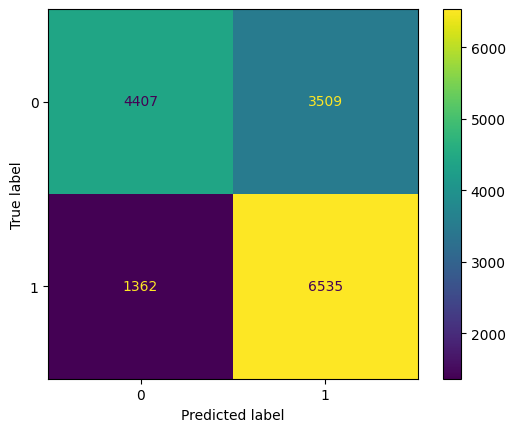

In [96]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(rf_fitted_grid.best_estimator_, X_test_scaled, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `4407` are correctly predicted as negative Tweet
* **False Positive**: `3509` that where incorrectly classified as positive Tweet

* **False Negative**: `1362` incorrectly predicted as a negative Tweet 
* **True Positive**: `6535` correctly predicted as postive Tweet

There has been a drop in predicting True Negative, and an increase in False Positive. It seems like it didn't predict well for both classes.


In [98]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.56      0.64      7916
           1       0.65      0.83      0.73      7897

    accuracy                           0.69     15813
   macro avg       0.71      0.69      0.69     15813
weighted avg       0.71      0.69      0.69     15813



**Observations:**

* We can see a drop in an accuracy score
    
* Precision shows that 65% of samples predicted class 1, and 76% predicted samples as class 0.
    
* Recall: 83% were predicted right out of all true class instances of class 1, we saw a significant increase in recall of class 1, and 56% predicted class 0

| GridSearch Best Model |                              Train Score                              | Train Score | Validation score | Test score |
|:---------------------:|:---------------------------------------------------------------------:|:-----------:|:----------------:|:----------:|
|  Logistic Regression  | C=1, max_iter=10000, penalty='l1', random_state=1,,solver='liblinear' |    76.5%    |        76%       |    74.9%   |
|       LinearSVC       |          C=0.1, max_iter=10000, random_state=1, penalty='l2'          |    76.6%    |       76.4%      |    74.5%   |
|     Random Forest     |             max_depth=11, n_estimators=200, random_state=1            |    70.6%    |       70.2%      |    69.2%   |


|    Baseline Model   |         Default Model Parameters        | Train Score | Validation score | Test score |
|:-------------------:|:---------------------------------------:|:-----------:|:----------------:|:----------:|
| Logistic Regression | C = 1, penalty = 'l2', solver = 'lbfgs' |     77%     |       74.3%      |    74.1%   |

Running our third model `Random Forest` didn't quite go well in terms of accuracy score, as well as most of the scores in the tables got dropped 

Let's have a look at our last model.

#### XG Boost

Our hyperparameter will include

* n_estimators = range(50, 201, 50)
* max_depth = range(3, 12, 2)
* learning_rate = [0.1, 0.3, 0.5, 0.7]
* random_state = 1

In [131]:
# XGBoost
xgb_param_grid = {
    'scaler': [RobustScaler()],
    'model': [XGBClassifier(random_state = 1)],
    'model__n_estimators': range(50, 201, 50),
    'model__max_depth': range(3, 12, 2),
    'model__learning_rate': [0.1, 0.3, 0.5, 0.7]
}

In [132]:
# Instantiate the grid search for each model
xgb_grid = GridSearchCV(my_pipe, param_grid =xgb_param_grid, cv = 5, verbose = 2)

In [133]:
# Fit the grid search for all models
xgb_fitted_grid = xgb_grid.fit(X_rem, y_rem.values.ravel())

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50, scaler=RobustScaler(); total time=  17.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None

In [134]:
# best score
print(f"best score: {xgb_fitted_grid.best_score_}")

# best parameters
print(f"best parameters: {xgb_fitted_grid.best_params_}")

best score: 0.732675644655626
best parameters: {'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=None, max_depth=9,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              random_state=1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), 'model__learning_rate': 0.3, 'model__max_depth': 9, 'model__n_estimators': 200, 'scaler': RobustScaler()}


In [137]:
# Saving a model
joblib.dump(xgb_fitted_grid, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [101]:
# sanity check - if loads
xgb_fitted_grid = joblib.load('xgboost_model.pkl')

In [102]:
# sanity check to make sure the models are loaded correctly
xgb_fitted_grid.best_params_

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.3, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=200, n_jobs=None, num_parallel_tree=None,
               random_state=1, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'model__learning_rate': 0.3,
 'model__max_depth': 9,
 'model__n_estimators': 200,
 'scaler': RobustScaler()}

In [106]:
# Initializing the model 
xg_model = XGBClassifier(learning_rate=0.3, max_depth=9, n_estimators=200, random_state=1)

#Fitting the model
xg_model.fit(X_train_scaled, y_train)

#Printing scores
print("Train score", xg_model.score(X_train_scaled, y_train))
print("Validation score", xg_model.score(X_val_scaled, y_val))
print("Test score", xg_model.score(X_test_scaled, y_test))

Train score 0.8186068572977369
Validation score 0.732437417654809
Test score 0.7295263390880921


That's great the Train score has increased 4% but there seem to be overfit. We can explore more.

In [107]:
# Get class predictions
y_pred = xg_model.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5367,2549
True Positive,1728,6169


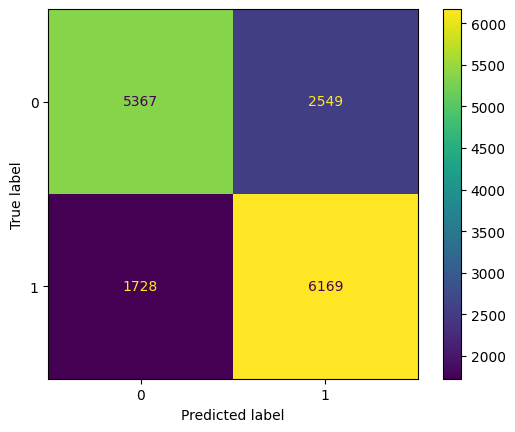

In [108]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(xg_model, X_test_scaled, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `5367` are correctly predicted as negative Tweet
* **False Positive**: `2549` that where incorrectly classified as positive Tweet

* **False Negative**: `1728` incorrectly predicted as a negative Tweet 
* **True Positive**: `6169` correctly predicted as postive Tweet


In [109]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      7916
           1       0.71      0.78      0.74      7897

    accuracy                           0.73     15813
   macro avg       0.73      0.73      0.73     15813
weighted avg       0.73      0.73      0.73     15813



**Observations:**

* We can see 73% of the accuracy got predicted correctly
    
* Precision shows that 71% of samples predicted class 1, and 76% predicted samples as class 0.
    
* Recall: 78% were predicted right out of all true class instances of class 1 and 68% predicted class 0

| GridSearch Best Model |                                  Train Score                                 | Train Score | Validation score | Test score |
|:---------------------:|:----------------------------------------------------------------------------:|:-----------:|:----------------:|:----------:|
|  Logistic Regression  |     C=1, max_iter=10000, penalty='l1', random_state=1,,solver='liblinear'    |    76.5%    |        76%       |    74.9%   |
|       LinearSVC       |              C=0.1, max_iter=10000, random_state=1, penalty='l2'             |    76.6%    |       76.4%      |    74.5%   |
|     Random Forest     |                max_depth=11, n_estimators=200, random_state=1                |    70.6%    |       70.2%      |    69.2%   |
|        XG Boost       | learning_rate=0.3, max_depth=9 n_estimators=200, n_jobs=None, random_state=1 |    81.8%    |       73.2%      |    72.9%   |


|    Baseline Model   |         Default Model Parameters        | Train Score | Validation score | Test score |
|:-------------------:|:---------------------------------------:|:-----------:|:----------------:|:----------:|
| Logistic Regression | C = 1, penalty = 'l2', solver = 'lbfgs' |     77%     |       74.3%      |    74.1%   |

Running our final model, we can observe that the Train score has the highest accuracy score, however it's overfitting.

***On the basis of these results, the baseline model has the best performance.***

### Final Model

There are advantages with using a baseline model which are:
* No required hyperparameter, we can run the default parameters
* Less computational and can run on local machine
* Easy to interpret and evaluate

Now that I have chosen my best model for this project. We can go ahead and save the pkl file

In [142]:
# Saving the baseline model - baseline logistic regression
joblib.dump(logreg_model, 'baseline_logreg.pkl')

['baseline_logreg.pkl']

Let's have a look again on the model evaluation on baseline model

In [117]:
X_test_scaled.shape

(15813, 2000)

In [136]:
# Get class predictions
y_pred = logreg_model.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5705,2211
True Positive,1888,6009


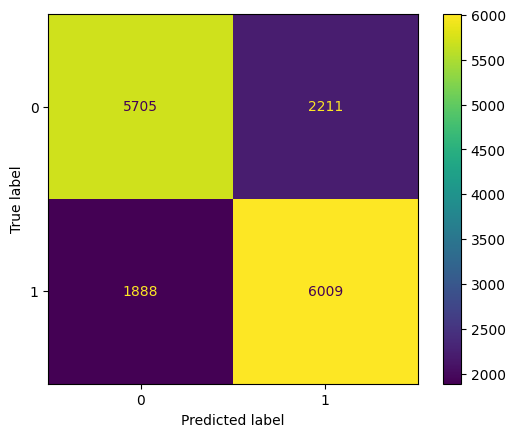

In [137]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model, X_test_scaled, y_test)

Let's interpret these numbers of the confusion matrix:

* **True Negative**: `5722` are correctly predicted as negative Tweet
* **False Positive**: `2217` that where incorrectly classified as positive Tweet

* **False Negative**: `1866` incorrectly predicted as a negative Tweet 
* **True Positive**: `6008` correctly predicted as postive Tweet

The total of True values (TP + TN) are much higher than the total of False values (FP + FN) indicating a higher accuracy

But with regards to sentiment analysis we want a higher recall rate (how well the model identifies the positive or negative Tweet correctly vs the total positive or negative in the dataset)

In [138]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      7916
           1       0.73      0.76      0.75      7897

    accuracy                           0.74     15813
   macro avg       0.74      0.74      0.74     15813
weighted avg       0.74      0.74      0.74     15813



**Observations:**

* As our base model we have a good accuracy score with `74%`.
    
* Precision shows that 73% of samples predicted class 1 and 75% predicted samples as class 0.
    
* Recall: 76% were predicted right out of all true class instances of class 1 and 72% predicted class 0

In [139]:
# Make probabilistic predictions (scores)
y_proba = logreg_model.predict_proba(X_test_scaled)[:,1]

In [140]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.731021897810219
Recall score: 0.7609218690642016

Threshold of 0.2:
Precision score: 0.5898946063236206
Recall score: 0.9639103457008991


So by reducing the y_proba from 0.5 to 0.2 we see an increase significantly in a Recall by 20% increase

Let's plot a graph

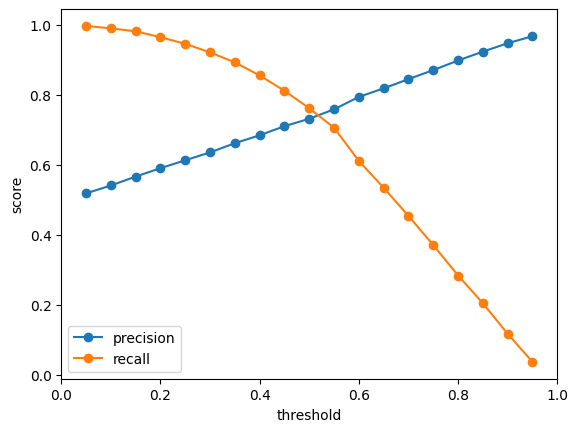

In [141]:
from sklearn.metrics import accuracy_score

# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

From the plot above, the optimal threshold value is between 0.2 and 0.4 

### 4. Conclusion

In this notebook we looked at advanced modelling, the baseline Logistic Regression model was the most successful at classifying the positive and negative Tweets.

Best Model Parameters:

|    Baseline Model   |         Default Model Parameters        | Train Score | Validation score | Test score |
|:-------------------:|:---------------------------------------:|:-----------:|:----------------:|:----------:|
| Logistic Regression | C = 1, penalty = 'l2', solver = 'lbfgs' |     77%     |       74.3%      |    74.1%   |

In Next Steps:

Search for another dataset to enhance the training 
Conduct a Nueral Network to turn image into text and implement NLP
Work on unsupervised learning by clustering
Build an interactive app